<h1 align="center">EPFL Machine Learning Course CS-433 Road Segmentation Project</h1>

<h3 align="center">Efe Tarhan || Sabri Yiğit Arslan || Eren Akçanal</h1>

## Introduction 

## 0. Importing Necessary Libraries

The following are the necessary libraries for this project: 
```markdown
- numpy==1.24.4
- torch==1.13.0
- matplotlib==3.7.5
- scikit-learn==1.3.2
- PIL==10.4.0
- opencv-python==4.10.0
- albumentations==1.4.18
- tqdm==4.67.1
- transformations==4.46.3
```


In [1]:
import os 
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import sklearn
import tqdm
import albumentations as A 
from tqdm import tqdm
from PIL import Image
from transformers import SegformerImageProcessor
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import cv2 as cv


/home/efe/Desktop/ml-project-2-middle_earth/.venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Setting the random seed for reproducibilty 

In [2]:
random_state = 0
torch.manual_seed(random_state)
np.random.seed(random_state)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The current used device is: " + device.type)

The current used device is: cuda


## 1. Preprocessing of the Dataset and Preparing it for the Task. 

Assuming that the dataset is already unzipped and located in the following assemble of files:  


```plaintext
project/
|
├── train/
│   ├── images/
│   │   ├── satImage_001.png
│   │   ├── satImage_002.png
│   │   ├── satImage_003.png
│   │            .
│   │            .
│   │   ├── satImage_100.png
│   ├── groundtruth/
│   │   ├── satImage_001.png
│   │   ├── satImage_002.png
│   │   ├── satImage_002.png
│   │            .
│   │            .
│   │   ├── satImage_100.png
├── test/
│   │   ├── test_1.png
│   │   ├── test_2.png
│   │   ├── test_3.png
│   │            .
│   │            .
│   │   ├── test_50.png
├── notebooks/
│   │── segformer_notebook.ipynb
```

By using considering this file hierarchy the files will be loaded as shown below

### 1.1 Creating a temporary holder for visualizing the dataset

In [3]:
path = "/home/efe/Desktop/ml-project-2-middle_earth/train/"
image_path = path + "images/"
mask_path = path + "groundtruth/" 
target_size = (608,608) 

files = os.listdir(image_path)
sorted_image_files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
images = []
for file_name in sorted_image_files:
        image = Image.open(image_path + file_name)
        image = np.array(image).astype(np.float32)
        image = image / 255.0
        images.append(image)

files = os.listdir(mask_path)
sorted_mask_files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
masks = []
for file_name in sorted_mask_files:
        mask = Image.open(mask_path + file_name)
        mask = np.array(mask).astype(np.float32)
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)
        masks.append(mask)

The first image - mask pair in the dataset can be seen below. 

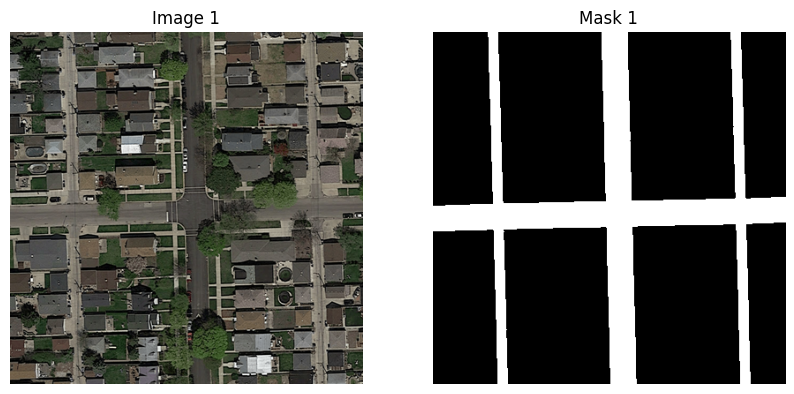

In [4]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis("off")
plt.subplot(1,2,2)  
plt.imshow(masks[0],cmap="gray")
plt.title("Mask 1")
plt.axis("off")
plt.show()

### 1.3 Applying Preprocessing to the Data

In [5]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),                                    # Randomly flip horizontally
    A.VerticalFlip(p=0.5),                                      # Randomly flip vertically
    A.ShiftScaleRotate(shift_limit=0.0,                         # No shifting
                       scale_limit=0.0,                         # No scaling
                       rotate_limit=90,                         # Rotate within [-60, 60] degrees
                       p=1.0),                                  # Always apply
    A.RandomBrightnessContrast(p=1),                            # Randomly change brightness and contrast
    A.RandomGamma(p=1),                                         # Randomly change gamma
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change hue, saturation, and value
    A.CoarseDropout(max_holes=3, max_height=50, max_width=50,   # Randomly drop up to 5 50x50 pixel squares
                    min_holes=1, min_height=20, min_width=20, 
                    fill_value=0, p=1.0),                       # Always apply 
])

validation_transform = A.Compose([
])

These transforms will be applied with 100% probability and therefore the dataset size must be increased. 

### 1.4 Creating the New Custom Dataset Class and Data Loader Functions for Training

In [6]:
path = "/home/efe/Desktop/ml-project-2-middle_earth/train/"
def tr_te_split(root_dir):
    """
    Split the dataset into training and validation sets.

    Args:
        root_dir (string): Root directory of the dataset containing the images + annotations.
    Returns:
        train_images (list): List of training images.
        val_images (list): List of validation images.
        train_annotations (list): List of training segmentation maps.
        val_annotations (list): List of validation segmentation maps.
    """
    img_dir = os.path.join(root_dir, "images")
    ann_dir = os.path.join(root_dir, "groundtruth")
    images = sorted([path + "images/" + f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    annotations = sorted([path + "groundtruth/" + f for f in os.listdir(ann_dir) if f.endswith('.png')])
    assert len(images) == len(annotations), "Number of images and masks must be equal."
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.1, random_state=0)
    return train_images, val_images, train_annotations, val_annotations

train_images, val_images, train_annotations, val_annotations = tr_te_split(path)

class TrainDataset(Dataset):
    """
    Image (semantic) segmentation dataset.
    """

    def __init__(self, image_list,mask_list,image_processor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """

        self.image_processor = image_processor
        self.images = image_list
        self.masks = mask_list
        assert len(self.images) == len(self.masks), "There must be as many images as there are segmentation maps"

    def __len__(self):
        """
        Returns the number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Returns the encoded inputs for the image and segmentation map at the given index.
        
        Args:
            idx (int): Index of the image and segmentation map to return.
        
        Returns:
            dict: Encoded inputs for the image and segmentation map at the given index.
        """

        image = Image.open(self.images[idx])
        image = np.array(image)
        segmentation_map = Image.open( self.masks[idx])
        segmentation_map = np.array(segmentation_map)
        segmentation_map = (segmentation_map > 125).astype(np.uint8) 
        augmented = train_transform(image=image, mask=segmentation_map)
        image = augmented['image']
        segmentation_map = augmented['mask']
        image = Image.fromarray(image)
        segmentation_map = Image.fromarray(segmentation_map)
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() 

        return encoded_inputs
    
class ValidationDataset(Dataset):
    """
    Image (semantic) segmentation dataset.
    """
    def __init__(self, image_list,mask_list,image_processor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.image_processor = image_processor
        self.images = image_list
        self.masks = mask_list
        assert len(self.images) == len(self.masks), "There must be as many images as there are segmentation maps"

    def __len__(self):
        """
        Returns the number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Returns the encoded inputs for the image and segmentation map at the given index.
        
        Args:
            idx (int): Index of the image and segmentation map to return.
        
        Returns:
            dict: Encoded inputs for the image and segmentation map at the given index.
            
        """
        image = Image.open(self.images[idx])
        image = np.array(image)
        segmentation_map = Image.open( self.masks[idx])
        segmentation_map = np.array(segmentation_map)
        segmentation_map = (segmentation_map > 125).astype(np.uint8) 
        augmented = validation_transform(image=image, mask=segmentation_map)
        image = augmented['image']
        segmentation_map = augmented['mask']
        image = Image.fromarray(image)
        segmentation_map = Image.fromarray(segmentation_map)
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_()

        return encoded_inputs
   
feature_extractor = SegformerImageProcessor(reduce_labels=False)
train_dataset = TrainDataset(image_list=train_images,mask_list=train_annotations,image_processor=feature_extractor)
val_dataset = ValidationDataset(image_list=val_images,mask_list=val_annotations,image_processor=feature_extractor)

Now the DataLoaders can be prepared for the inference 

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

## 2. Defining the Model

In [8]:
from transformers import SegformerForSemanticSegmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nvidia/segformer-b4-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=2,
    id2label={0: "no_road", 1: "road"},
    label2id={"no_road": 0, "road": 1},
    ignore_mismatched_sizes=True).to(device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3. Defining the Optimizer and the Scheduler

#### 3.1 Defining the Hyperparameters of the Training

In [9]:
NUM_EPOCHS = 150
LEARNING_RATE = 1e-3
STEP_SIZE = 10
GAMMA = 0.3

#### 3.2 Defining the Optimizer and the Scheduler

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## 4. Training the Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
f1_scores = []
for epoch in range(NUM_EPOCHS): 
      print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
      print("-" * 10)
      model.train()
      epoch_loss = 0.0
      for idx, batch in enumerate(tqdm(train_loader)):
            image = batch["pixel_values"].to(device)
            mask = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=image, labels=mask)
            loss, logits = outputs.loss, outputs.logits
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
      lr_scheduler.step()
      train_losses.append(epoch_loss/ len(train_dataset))
      print("Train Loss:", epoch_loss/ len(train_dataset))
      model.eval()
      with torch.no_grad():
            total_loss = 0
            msks = []
            pres = []
            for i, batch in enumerate(tqdm(val_loader)):
                  image = batch["pixel_values"].to(device)
                  mask = batch["labels"].to(device)
                  output = model(pixel_values=image, labels=mask)
                  loss, logits = output.loss, output.logits
                  preds = F.interpolate(logits, size=(608, 608), mode='bilinear', align_corners=False)
                  mask = F.interpolate(mask.unsqueeze(1).float(), size=(608, 608), mode='nearest').squeeze(1)[0]
                  preds = preds.argmax(dim=1)[0].cpu().numpy()
                  total_loss += loss.item()
                  msks.append(mask.cpu().numpy())
                  pres.append(preds)
            f1_score = sklearn.metrics.f1_score(np.vstack(msks).flatten(), np.vstack(pres).flatten(), average='binary')
            f1_scores.append(f1_score)
            print(f"Validation Loss: {total_loss / len(val_dataset)}, F1 Score: {f1_score}")
            print("-" * 10)

model_dict = model.state_dict()
torch.save(model_dict, "/home/efe/Desktop/ml-project-2-middle_earth/model_dicts/segformer.pth")

Epoch 1/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.65it/s]


Train Loss: 0.19146802475055058


100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


Validation Loss: 0.25988394767045975, F1 Score: 0.7292007145790502
----------
Epoch 2/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.14766200847095914


100%|██████████| 10/10 [00:00<00:00, 15.15it/s]


Validation Loss: 0.2099722608923912, F1 Score: 0.7540884932592874
----------
Epoch 3/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Train Loss: 0.12658878829744127


100%|██████████| 10/10 [00:00<00:00, 14.76it/s]


Validation Loss: 0.1799067012965679, F1 Score: 0.8096632412381418
----------
Epoch 4/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


Train Loss: 0.12057891802655327


100%|██████████| 10/10 [00:00<00:00, 13.44it/s]


Validation Loss: 0.16953656524419786, F1 Score: 0.8369903700033493
----------
Epoch 5/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


Train Loss: 0.11415916697846519


100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Validation Loss: 0.205982805788517, F1 Score: 0.7931046396054023
----------
Epoch 6/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Train Loss: 0.1097500747276677


100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Validation Loss: 0.16429107263684273, F1 Score: 0.8358262991600447
----------
Epoch 7/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Train Loss: 0.10948010252581702


100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


Validation Loss: 0.21549716591835022, F1 Score: 0.7196162149701055
----------
Epoch 8/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


Train Loss: 0.12213522493839264


100%|██████████| 10/10 [00:00<00:00, 15.24it/s]


Validation Loss: 0.1774800166487694, F1 Score: 0.8135563441332516
----------
Epoch 9/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Train Loss: 0.119029700756073


100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


Validation Loss: 0.19003476500511168, F1 Score: 0.822514459715295
----------
Epoch 10/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.41it/s]


Train Loss: 0.107435375948747


100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


Validation Loss: 0.1611194856464863, F1 Score: 0.8394046146282178
----------
Epoch 11/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Train Loss: 0.09989620082908207


100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


Validation Loss: 0.13408830389380455, F1 Score: 0.8691833010750182
----------
Epoch 12/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Train Loss: 0.08527041292852826


100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Validation Loss: 0.14734782725572587, F1 Score: 0.853077562448051
----------
Epoch 13/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Train Loss: 0.0815014482372337


100%|██████████| 10/10 [00:00<00:00, 12.32it/s]


Validation Loss: 0.12618231847882272, F1 Score: 0.8709002897667061
----------
Epoch 14/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Train Loss: 0.07605431924263636


100%|██████████| 10/10 [00:00<00:00, 13.28it/s]


Validation Loss: 0.12849379628896712, F1 Score: 0.8615779662666477
----------
Epoch 15/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Train Loss: 0.07520825424128108


100%|██████████| 10/10 [00:00<00:00, 12.17it/s]


Validation Loss: 0.1258312687277794, F1 Score: 0.8682267036142517
----------
Epoch 16/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Train Loss: 0.07421233587794834


100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


Validation Loss: 0.12241567820310592, F1 Score: 0.8761590186897474
----------
Epoch 17/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Train Loss: 0.067503648582432


100%|██████████| 10/10 [00:00<00:00, 10.23it/s]


Validation Loss: 0.12545997947454451, F1 Score: 0.8711773139717492
----------
Epoch 18/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Train Loss: 0.0732138497961892


100%|██████████| 10/10 [00:00<00:00, 13.99it/s]


Validation Loss: 0.12203829810023308, F1 Score: 0.8757094823530427
----------
Epoch 19/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Train Loss: 0.06738051945964495


100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


Validation Loss: 0.12408994063735009, F1 Score: 0.8778063820870502
----------
Epoch 20/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


Train Loss: 0.06610099565651682


100%|██████████| 10/10 [00:00<00:00, 12.96it/s]


Validation Loss: 0.12397354543209076, F1 Score: 0.8632842497243606
----------
Epoch 21/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Train Loss: 0.06418166450328297


100%|██████████| 10/10 [00:00<00:00, 10.90it/s]


Validation Loss: 0.12409607321023941, F1 Score: 0.8677382933556009
----------
Epoch 22/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Train Loss: 0.057781875174906516


100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


Validation Loss: 0.1252970926463604, F1 Score: 0.86055450041528
----------
Epoch 23/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Train Loss: 0.06025636684563425


100%|██████████| 10/10 [00:00<00:00, 12.17it/s]


Validation Loss: 0.12504682391881944, F1 Score: 0.8698618606649017
----------
Epoch 24/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Train Loss: 0.05765567525393433


100%|██████████| 10/10 [00:00<00:00, 12.90it/s]


Validation Loss: 0.12185707911849022, F1 Score: 0.8736186233722609
----------
Epoch 25/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Train Loss: 0.058209477406409055


100%|██████████| 10/10 [00:00<00:00, 12.67it/s]


Validation Loss: 0.11602080576121807, F1 Score: 0.8840321479177928
----------
Epoch 26/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.58it/s]


Train Loss: 0.056726365577843454


100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Validation Loss: 0.11987323649227619, F1 Score: 0.8792845297496367
----------
Epoch 27/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.50it/s]


Train Loss: 0.05506671236621009


100%|██████████| 10/10 [00:00<00:00, 11.81it/s]


Validation Loss: 0.1233450260013342, F1 Score: 0.8762345847578891
----------
Epoch 28/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Train Loss: 0.055113339092996386


100%|██████████| 10/10 [00:00<00:00, 11.48it/s]


Validation Loss: 0.12603609040379524, F1 Score: 0.8737952104070168
----------
Epoch 29/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Train Loss: 0.05689122656153308


100%|██████████| 10/10 [00:00<00:00, 13.49it/s]


Validation Loss: 0.11864041015505791, F1 Score: 0.8774415345699458
----------
Epoch 30/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Train Loss: 0.0551427510049608


100%|██████████| 10/10 [00:00<00:00, 10.95it/s]


Validation Loss: 0.11864221468567848, F1 Score: 0.8819725506541041
----------
Epoch 31/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Train Loss: 0.05304018664691183


100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


Validation Loss: 0.12158610373735428, F1 Score: 0.8795363406170872
----------
Epoch 32/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


Train Loss: 0.0539125084463093


100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


Validation Loss: 0.11618958450853825, F1 Score: 0.8854319001477201
----------
Epoch 33/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Train Loss: 0.05415262811713749


100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


Validation Loss: 0.11668803691864013, F1 Score: 0.8846582693013912
----------
Epoch 34/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


Train Loss: 0.054095270443293784


100%|██████████| 10/10 [00:00<00:00, 11.75it/s]


Validation Loss: 0.11800620779395103, F1 Score: 0.8808755275131209
----------
Epoch 35/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Train Loss: 0.05250927690002653


100%|██████████| 10/10 [00:00<00:00, 12.68it/s]


Validation Loss: 0.12071147710084915, F1 Score: 0.8802116348327373
----------
Epoch 36/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


Train Loss: 0.05274135445555051


100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


Validation Loss: 0.12051310762763023, F1 Score: 0.8820955036629285
----------
Epoch 37/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Train Loss: 0.0509760693129566


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]


Validation Loss: 0.11998526379466057, F1 Score: 0.8854362242957763
----------
Epoch 38/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


Train Loss: 0.0504753578454256


100%|██████████| 10/10 [00:00<00:00, 13.83it/s]


Validation Loss: 0.11791785210371017, F1 Score: 0.8843943514011576
----------
Epoch 39/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Train Loss: 0.051459171540207335


100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Validation Loss: 0.11911191046237946, F1 Score: 0.8842998678112124
----------
Epoch 40/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Train Loss: 0.05046990828381644


100%|██████████| 10/10 [00:00<00:00, 13.32it/s]


Validation Loss: 0.12338182851672172, F1 Score: 0.8818233888210828
----------
Epoch 41/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.40it/s]


Train Loss: 0.05079588770038552


100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


Validation Loss: 0.12149485535919666, F1 Score: 0.8840230772046491
----------
Epoch 42/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Train Loss: 0.049716339260339734


100%|██████████| 10/10 [00:00<00:00, 14.27it/s]


Validation Loss: 0.118681850284338, F1 Score: 0.8862590128386665
----------
Epoch 43/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.41it/s]


Train Loss: 0.04946642729143302


100%|██████████| 10/10 [00:00<00:00, 15.02it/s]


Validation Loss: 0.12141829542815685, F1 Score: 0.8852196138261884
----------
Epoch 44/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


Train Loss: 0.04974346777631177


100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


Validation Loss: 0.11987056620419026, F1 Score: 0.8851279622461392
----------
Epoch 45/150
----------


100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


Train Loss: 0.049793374497029516


100%|██████████| 10/10 [00:00<00:00, 13.67it/s]


Validation Loss: 0.12144988477230072, F1 Score: 0.8865863991313996
----------
Epoch 46/150
----------


100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


Train Loss: 0.05013583244548903


100%|██████████| 10/10 [00:00<00:00, 14.70it/s]


Validation Loss: 0.12148544676601887, F1 Score: 0.8860219685870296
----------
Epoch 47/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Train Loss: 0.04883330352604389


100%|██████████| 10/10 [00:00<00:00, 14.00it/s]


Validation Loss: 0.12088393308222294, F1 Score: 0.8863247033521764
----------
Epoch 48/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Train Loss: 0.04994529895484447


100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


Validation Loss: 0.11853330358862876, F1 Score: 0.8868206505591671
----------
Epoch 49/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


Train Loss: 0.04915676903393534


100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Validation Loss: 0.11982699632644653, F1 Score: 0.8853156177751512
----------
Epoch 50/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.76it/s]


Train Loss: 0.05056566877497567


100%|██████████| 10/10 [00:00<00:00, 12.84it/s]


Validation Loss: 0.12085453569889068, F1 Score: 0.8861865893065215
----------
Epoch 51/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Train Loss: 0.05017780802316136


100%|██████████| 10/10 [00:00<00:00, 13.39it/s]


Validation Loss: 0.11896252818405628, F1 Score: 0.8869743418785992
----------
Epoch 52/150
----------


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Train Loss: 0.049457663007908395


100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Validation Loss: 0.12062389738857746, F1 Score: 0.8858789849269056
----------
Epoch 53/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.10it/s]


Train Loss: 0.04980250261723995


100%|██████████| 10/10 [00:00<00:00, 15.20it/s]


Validation Loss: 0.12352224253118038, F1 Score: 0.8858004767756977
----------
Epoch 54/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


Train Loss: 0.04869446990390618


100%|██████████| 10/10 [00:00<00:00, 17.42it/s]


Validation Loss: 0.12058635205030441, F1 Score: 0.8872903067273336
----------
Epoch 55/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.16it/s]


Train Loss: 0.04885633227725824


100%|██████████| 10/10 [00:00<00:00, 16.71it/s]


Validation Loss: 0.11791214495897293, F1 Score: 0.886431063536895
----------
Epoch 56/150
----------


100%|██████████| 45/45 [00:13<00:00,  3.24it/s]


Train Loss: 0.05032844071586927


100%|██████████| 10/10 [00:00<00:00, 17.49it/s]


Validation Loss: 0.11976710706949234, F1 Score: 0.8867417641689487
----------
Epoch 57/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.04880832942823569


100%|██████████| 10/10 [00:00<00:00, 17.58it/s]


Validation Loss: 0.1188794419169426, F1 Score: 0.8872412247060698
----------
Epoch 58/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.15it/s]


Train Loss: 0.04951914105978277


100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Validation Loss: 0.12095761373639106, F1 Score: 0.8867350672715254
----------
Epoch 59/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.04833109428485235


100%|██████████| 10/10 [00:00<00:00, 17.04it/s]


Validation Loss: 0.11958187334239483, F1 Score: 0.8873326173426432
----------
Epoch 60/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.93it/s]


Train Loss: 0.049000456722246274


100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


Validation Loss: 0.11995628178119659, F1 Score: 0.8877257425434365
----------
Epoch 61/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.95it/s]


Train Loss: 0.049299760825104184


100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


Validation Loss: 0.1190136257559061, F1 Score: 0.887481621539186
----------
Epoch 62/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


Train Loss: 0.049301627195543714


100%|██████████| 10/10 [00:00<00:00, 15.29it/s]


Validation Loss: 0.12318914979696274, F1 Score: 0.8861960532002159
----------
Epoch 63/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.00it/s]


Train Loss: 0.04847554858360026


100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Validation Loss: 0.12074885070323944, F1 Score: 0.8865126912436562
----------
Epoch 64/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.048609725344512196


100%|██████████| 10/10 [00:00<00:00, 16.68it/s]


Validation Loss: 0.11914370134472847, F1 Score: 0.8872719659867127
----------
Epoch 65/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.17it/s]


Train Loss: 0.04936881069507864


100%|██████████| 10/10 [00:00<00:00, 17.29it/s]


Validation Loss: 0.1204874936491251, F1 Score: 0.8868523077288998
----------
Epoch 66/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.04941842332482338


100%|██████████| 10/10 [00:00<00:00, 16.64it/s]


Validation Loss: 0.1189977504312992, F1 Score: 0.8868671179766187
----------
Epoch 67/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.04827899858355522


100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Validation Loss: 0.11893365159630775, F1 Score: 0.8864996816594172
----------
Epoch 68/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


Train Loss: 0.04977033448716005


100%|██████████| 10/10 [00:00<00:00, 17.29it/s]


Validation Loss: 0.12041285298764706, F1 Score: 0.8868992891594586
----------
Epoch 69/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.03it/s]


Train Loss: 0.04911726667649216


100%|██████████| 10/10 [00:00<00:00, 16.19it/s]


Validation Loss: 0.11892792135477066, F1 Score: 0.8864835385075023
----------
Epoch 70/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.14it/s]


Train Loss: 0.049379092040989135


100%|██████████| 10/10 [00:00<00:00, 15.60it/s]


Validation Loss: 0.120658291131258, F1 Score: 0.8863655005689555
----------
Epoch 71/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


Train Loss: 0.0479167892701096


100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


Validation Loss: 0.120170858502388, F1 Score: 0.8876657144297999
----------
Epoch 72/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


Train Loss: 0.0492865689098835


100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


Validation Loss: 0.12206564657390118, F1 Score: 0.8859146143524121
----------
Epoch 73/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.95it/s]


Train Loss: 0.04981701581014527


100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Validation Loss: 0.12225486412644386, F1 Score: 0.8867764388881892
----------
Epoch 74/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.02it/s]


Train Loss: 0.05039650665389167


100%|██████████| 10/10 [00:00<00:00, 15.45it/s]


Validation Loss: 0.11841901242733002, F1 Score: 0.8877913358823293
----------
Epoch 75/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.04924031930665175


100%|██████████| 10/10 [00:00<00:00, 17.21it/s]


Validation Loss: 0.12085448130965233, F1 Score: 0.8874317313349458
----------
Epoch 76/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.12it/s]


Train Loss: 0.04881843374007278


100%|██████████| 10/10 [00:00<00:00, 17.50it/s]


Validation Loss: 0.11967118345201015, F1 Score: 0.887475223517477
----------
Epoch 77/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.99it/s]


Train Loss: 0.04868444800376892


100%|██████████| 10/10 [00:00<00:00, 15.05it/s]


Validation Loss: 0.12028834670782089, F1 Score: 0.886601026631611
----------
Epoch 78/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.04943309293852912


100%|██████████| 10/10 [00:00<00:00, 17.35it/s]


Validation Loss: 0.12025608159601689, F1 Score: 0.8874720210225338
----------
Epoch 79/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.049375481199887064


100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


Validation Loss: 0.11933269426226616, F1 Score: 0.886939040728234
----------
Epoch 80/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.93it/s]


Train Loss: 0.048380960317121614


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]


Validation Loss: 0.11896640732884407, F1 Score: 0.8873030068017619
----------
Epoch 81/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.87it/s]


Train Loss: 0.0489352452258269


100%|██████████| 10/10 [00:00<00:00, 13.24it/s]


Validation Loss: 0.12161759920418262, F1 Score: 0.8874759052029906
----------
Epoch 82/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.94it/s]


Train Loss: 0.049809461790654395


100%|██████████| 10/10 [00:00<00:00, 16.37it/s]


Validation Loss: 0.11893415451049805, F1 Score: 0.8880365283286957
----------
Epoch 83/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


Train Loss: 0.048505909285611576


100%|██████████| 10/10 [00:00<00:00, 17.35it/s]


Validation Loss: 0.12020553424954414, F1 Score: 0.8869793487071562
----------
Epoch 84/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.15it/s]


Train Loss: 0.04820476029482153


100%|██████████| 10/10 [00:00<00:00, 15.69it/s]


Validation Loss: 0.12287959679961205, F1 Score: 0.8856702771788558
----------
Epoch 85/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.15it/s]


Train Loss: 0.04950197405285305


100%|██████████| 10/10 [00:00<00:00, 15.81it/s]


Validation Loss: 0.12097274325788021, F1 Score: 0.8863286792053123
----------
Epoch 86/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


Train Loss: 0.049000748785005675


100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


Validation Loss: 0.1206303346902132, F1 Score: 0.8868802179303019
----------
Epoch 87/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


Train Loss: 0.04869643395973577


100%|██████████| 10/10 [00:00<00:00, 17.47it/s]


Validation Loss: 0.12076806910336017, F1 Score: 0.8863059723496388
----------
Epoch 88/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.048453113602267374


100%|██████████| 10/10 [00:00<00:00, 17.11it/s]


Validation Loss: 0.11807786896824837, F1 Score: 0.887869447793978
----------
Epoch 89/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.97it/s]


Train Loss: 0.04988913784424464


100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


Validation Loss: 0.11991599053144456, F1 Score: 0.8866482638384425
----------
Epoch 90/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.05029025827017095


100%|██████████| 10/10 [00:00<00:00, 15.75it/s]


Validation Loss: 0.12056714408099652, F1 Score: 0.8870217907224404
----------
Epoch 91/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.049247082364228034


100%|██████████| 10/10 [00:00<00:00, 14.21it/s]


Validation Loss: 0.11941565126180649, F1 Score: 0.8872072730134057
----------
Epoch 92/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.98it/s]


Train Loss: 0.047629155177209115


100%|██████████| 10/10 [00:00<00:00, 14.19it/s]


Validation Loss: 0.12086553871631622, F1 Score: 0.8867704488789198
----------
Epoch 93/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.14it/s]


Train Loss: 0.04892103568547302


100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


Validation Loss: 0.11840154938399791, F1 Score: 0.8880683742520735
----------
Epoch 94/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.20it/s]


Train Loss: 0.049324674490425324


100%|██████████| 10/10 [00:00<00:00, 15.12it/s]


Validation Loss: 0.12014031186699867, F1 Score: 0.8867820651789272
----------
Epoch 95/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


Train Loss: 0.0492603459291988


100%|██████████| 10/10 [00:00<00:00, 14.80it/s]


Validation Loss: 0.12000702135264874, F1 Score: 0.8872982110072665
----------
Epoch 96/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.14it/s]


Train Loss: 0.04815942694743474


100%|██████████| 10/10 [00:00<00:00, 16.36it/s]


Validation Loss: 0.12294601202011109, F1 Score: 0.8852405104159237
----------
Epoch 97/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.12it/s]


Train Loss: 0.04751238384180599


100%|██████████| 10/10 [00:00<00:00, 17.18it/s]


Validation Loss: 0.1190316166728735, F1 Score: 0.8879098885449559
----------
Epoch 98/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.17it/s]


Train Loss: 0.049474284590946306


100%|██████████| 10/10 [00:00<00:00, 16.14it/s]


Validation Loss: 0.12079780474305153, F1 Score: 0.8864304165441742
----------
Epoch 99/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.03it/s]


Train Loss: 0.048625846289926104


100%|██████████| 10/10 [00:00<00:00, 17.46it/s]


Validation Loss: 0.12031554207205772, F1 Score: 0.8865038749227291
----------
Epoch 100/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


Train Loss: 0.04978925097319815


100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


Validation Loss: 0.12161051034927368, F1 Score: 0.8858043711073751
----------
Epoch 101/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.05it/s]


Train Loss: 0.04968979735341337


100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


Validation Loss: 0.11867666766047477, F1 Score: 0.8872606025501072
----------
Epoch 102/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.17it/s]


Train Loss: 0.04856164409882492


100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Validation Loss: 0.12003863677382469, F1 Score: 0.8866789426736308
----------
Epoch 103/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.05it/s]


Train Loss: 0.048977962219052845


100%|██████████| 10/10 [00:00<00:00, 16.17it/s]


Validation Loss: 0.1209469385445118, F1 Score: 0.8872442218947099
----------
Epoch 104/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.19it/s]


Train Loss: 0.04937316266198953


100%|██████████| 10/10 [00:00<00:00, 17.24it/s]


Validation Loss: 0.11880701668560505, F1 Score: 0.8875261621318972
----------
Epoch 105/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.14it/s]


Train Loss: 0.048883381692899595


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Validation Loss: 0.11771277040243149, F1 Score: 0.8875867059936096
----------
Epoch 106/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


Train Loss: 0.049354042071435185


100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


Validation Loss: 0.12229637205600738, F1 Score: 0.8860019583953117
----------
Epoch 107/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.12it/s]


Train Loss: 0.04813178372051981


100%|██████████| 10/10 [00:00<00:00, 15.82it/s]


Validation Loss: 0.12117786109447479, F1 Score: 0.8864112621567891
----------
Epoch 108/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.15it/s]


Train Loss: 0.04935497633284992


100%|██████████| 10/10 [00:00<00:00, 17.35it/s]


Validation Loss: 0.12032831944525242, F1 Score: 0.8868142933915314
----------
Epoch 109/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


Train Loss: 0.048204952478408815


100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


Validation Loss: 0.11973524615168571, F1 Score: 0.8877086719741822
----------
Epoch 110/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.94it/s]


Train Loss: 0.048622507684760626


100%|██████████| 10/10 [00:00<00:00, 16.39it/s]


Validation Loss: 0.1207493782043457, F1 Score: 0.885533624778533
----------
Epoch 111/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.00it/s]


Train Loss: 0.04875326500170761


100%|██████████| 10/10 [00:00<00:00, 17.31it/s]


Validation Loss: 0.1214961476624012, F1 Score: 0.8870547453624427
----------
Epoch 112/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.89it/s]


Train Loss: 0.04914720315072271


100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Validation Loss: 0.11992636546492577, F1 Score: 0.8868887317124325
----------
Epoch 113/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.88it/s]


Train Loss: 0.049959877588682707


100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


Validation Loss: 0.11643003299832344, F1 Score: 0.8880836848937803
----------
Epoch 114/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.13it/s]


Train Loss: 0.04883032246596283


100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Validation Loss: 0.12141026854515076, F1 Score: 0.8876051675887431
----------
Epoch 115/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.82it/s]


Train Loss: 0.0486748273173968


100%|██████████| 10/10 [00:00<00:00, 16.89it/s]


Validation Loss: 0.12306209653615952, F1 Score: 0.8865303867815727
----------
Epoch 116/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.049057465294996896


100%|██████████| 10/10 [00:00<00:00, 17.48it/s]


Validation Loss: 0.11979588940739631, F1 Score: 0.8861929934059182
----------
Epoch 117/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


Train Loss: 0.049464108753535484


100%|██████████| 10/10 [00:00<00:00, 14.79it/s]


Validation Loss: 0.11785899251699447, F1 Score: 0.8872892051716578
----------
Epoch 118/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


Train Loss: 0.05001948107447889


100%|██████████| 10/10 [00:00<00:00, 17.21it/s]


Validation Loss: 0.11877515986561775, F1 Score: 0.8875144692007961
----------
Epoch 119/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.02it/s]


Train Loss: 0.04889759425487783


100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


Validation Loss: 0.11971791945397854, F1 Score: 0.8873021594764636
----------
Epoch 120/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.03it/s]


Train Loss: 0.05109291337430477


100%|██████████| 10/10 [00:00<00:00, 16.42it/s]


Validation Loss: 0.1203018706291914, F1 Score: 0.8867692490936567
----------
Epoch 121/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.049344637989997865


100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


Validation Loss: 0.1207990139722824, F1 Score: 0.886535547681258
----------
Epoch 122/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


Train Loss: 0.04906764320201344


100%|██████████| 10/10 [00:00<00:00, 16.20it/s]


Validation Loss: 0.12049248218536376, F1 Score: 0.8861686567164178
----------
Epoch 123/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.04974677844180001


100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


Validation Loss: 0.12045128755271435, F1 Score: 0.8866711603847716
----------
Epoch 124/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.04994701279534234


100%|██████████| 10/10 [00:00<00:00, 17.31it/s]


Validation Loss: 0.11849401295185089, F1 Score: 0.8875334424049324
----------
Epoch 125/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.19it/s]


Train Loss: 0.04875467440320386


100%|██████████| 10/10 [00:00<00:00, 16.16it/s]


Validation Loss: 0.11940909959375859, F1 Score: 0.8878306596394324
----------
Epoch 126/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


Train Loss: 0.04949207372135586


100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


Validation Loss: 0.12122074812650681, F1 Score: 0.8870299738878518
----------
Epoch 127/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.13it/s]


Train Loss: 0.0488617164393266


100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


Validation Loss: 0.12263281643390656, F1 Score: 0.8857642440235743
----------
Epoch 128/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.99it/s]


Train Loss: 0.04743535717328389


100%|██████████| 10/10 [00:00<00:00, 17.46it/s]


Validation Loss: 0.12076037228107453, F1 Score: 0.887095802616402
----------
Epoch 129/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.0502587854448292


100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


Validation Loss: 0.11801993288099766, F1 Score: 0.8870808297907712
----------
Epoch 130/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.02it/s]


Train Loss: 0.048845760938194066


100%|██████████| 10/10 [00:00<00:00, 14.91it/s]


Validation Loss: 0.12240983508527278, F1 Score: 0.8860837392435654
----------
Epoch 131/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.05it/s]


Train Loss: 0.048734077397320004


100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


Validation Loss: 0.12020140886306763, F1 Score: 0.887903093771785
----------
Epoch 132/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.03it/s]


Train Loss: 0.04821159061458376


100%|██████████| 10/10 [00:00<00:00, 14.69it/s]


Validation Loss: 0.11764547862112522, F1 Score: 0.8875255260193187
----------
Epoch 133/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.96it/s]


Train Loss: 0.049608157616522576


100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


Validation Loss: 0.12018244341015816, F1 Score: 0.8867720860331765
----------
Epoch 134/150
----------


100%|██████████| 45/45 [00:15<00:00,  3.00it/s]


Train Loss: 0.04946960434317589


100%|██████████| 10/10 [00:00<00:00, 17.36it/s]


Validation Loss: 0.12127539813518524, F1 Score: 0.8866537475497264
----------
Epoch 135/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.049621082842350006


100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Validation Loss: 0.11843733452260494, F1 Score: 0.8875395139735022
----------
Epoch 136/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.12it/s]


Train Loss: 0.0500828146106667


100%|██████████| 10/10 [00:00<00:00, 16.35it/s]


Validation Loss: 0.1215678546577692, F1 Score: 0.8861892898362885
----------
Epoch 137/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.04952130077613725


100%|██████████| 10/10 [00:00<00:00, 15.12it/s]


Validation Loss: 0.11959226429462433, F1 Score: 0.8871295343567295
----------
Epoch 138/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


Train Loss: 0.0494165969805585


100%|██████████| 10/10 [00:00<00:00, 16.26it/s]


Validation Loss: 0.12080212607979775, F1 Score: 0.8865222986962117
----------
Epoch 139/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.048561405597461596


100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Validation Loss: 0.12173802629113198, F1 Score: 0.8865194359471759
----------
Epoch 140/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.10it/s]


Train Loss: 0.04876152276992798


100%|██████████| 10/10 [00:00<00:00, 16.44it/s]


Validation Loss: 0.11821611300110817, F1 Score: 0.8874526607755633
----------
Epoch 141/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.048782124370336535


100%|██████████| 10/10 [00:00<00:00, 17.29it/s]


Validation Loss: 0.12086851112544536, F1 Score: 0.8868757788449149
----------
Epoch 142/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.89it/s]


Train Loss: 0.04927852720850044


100%|██████████| 10/10 [00:00<00:00, 15.62it/s]


Validation Loss: 0.12230008579790592, F1 Score: 0.8870358545016144
----------
Epoch 143/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.96it/s]


Train Loss: 0.04916784870955679


100%|██████████| 10/10 [00:00<00:00, 16.42it/s]


Validation Loss: 0.119272118806839, F1 Score: 0.887458690274839
----------
Epoch 144/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.13it/s]


Train Loss: 0.04905615978770786


100%|██████████| 10/10 [00:00<00:00, 14.16it/s]


Validation Loss: 0.12063837721943856, F1 Score: 0.8870762046628462
----------
Epoch 145/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.96it/s]


Train Loss: 0.049853089162045054


100%|██████████| 10/10 [00:00<00:00, 17.15it/s]


Validation Loss: 0.11854936704039573, F1 Score: 0.8877019828351584
----------
Epoch 146/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.88it/s]


Train Loss: 0.048499145400193004


100%|██████████| 10/10 [00:00<00:00, 17.20it/s]


Validation Loss: 0.1201330691576004, F1 Score: 0.8859880650967563
----------
Epoch 147/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.01it/s]


Train Loss: 0.04970190736154715


100%|██████████| 10/10 [00:00<00:00, 14.05it/s]


Validation Loss: 0.1191596258431673, F1 Score: 0.8874433864803912
----------
Epoch 148/150
----------


100%|██████████| 45/45 [00:15<00:00,  2.91it/s]


Train Loss: 0.048853128030896184


100%|██████████| 10/10 [00:00<00:00, 13.64it/s]


Validation Loss: 0.12154272273182869, F1 Score: 0.887244102690014
----------
Epoch 149/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.02it/s]


Train Loss: 0.04860870904392666


100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Validation Loss: 0.12100605703890324, F1 Score: 0.8869046776616831
----------
Epoch 150/150
----------


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


Train Loss: 0.048674801074796256


100%|██████████| 10/10 [00:00<00:00, 16.41it/s]


Validation Loss: 0.12021978758275509, F1 Score: 0.8871572931673204
----------


In [12]:
model_dict = model.state_dict()
torch.save(model_dict, "/home/efe/Desktop/ml-project-2-middle_earth/model_dicts/segformer.pth")

## 5. Testing the Model

In [13]:
class SemanticTestSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor

        self.img_dir = self.root_dir
        self.images = []
        for i in range(1,51):
            self.images.append(f"test_{i}.png")

    def __len__(self):
        """
        Returns the number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Returns the encoded inputs for the image and segmentation map at the given index.  

        Args:
            idx (int): Index of the image and segmentation map to return.
        
        Returns:
            dict: Encoded inputs for the image and segmentation map at the given index.
        """

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        encoded_inputs = self.image_processor(image, return_tensors="pt")
        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() 

        return encoded_inputs
feature_extractor = SegformerImageProcessor(reduce_labels=False)
test_set = SemanticTestSegmentationDataset("/home/efe/Desktop/ml-project-2-middle_earth/test",feature_extractor)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [22]:
# Test Phase 
import os
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation
from mask_to_submission import *
import matplotlib.pyplot as plt

os.chdir("/home/efe/Desktop/ml-project-2-middle_earth")
output_dir ="submission/predicted/"
os.makedirs(output_dir, exist_ok=True)
submission_file = "submission/submission.csv"


model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=2,
    id2label={0: "no_road", 1: "road"},
    label2id={"no_road": 0, "road": 1},
    ignore_mismatched_sizes=True).to(device)
model.load_state_dict(torch.load("model_dicts/segformer.pth"))

print("Generating predictions for the test set...")
model.eval()
image_filenames = []
all_preds = []
for idx, batch in enumerate(tqdm(test_loader)):    
    with torch.no_grad():
        image = batch["pixel_values"].to(device)
        image90 = torch.rot90(image, 1, [2, 3])
        image180 = torch.rot90(image, 2, [2, 3])
        image270 = torch.rot90(image, 3, [2, 3])

        # Forward pass for original image
        output = model(pixel_values=image)
        logits = output.logits
        logits = F.interpolate(logits, size=(608, 608), mode='bilinear', align_corners=False)

        # Forward pass for 90 degree rotated image
        output90 = model(pixel_values=image90)
        logits90 = output90.logits
        logits90 = F.interpolate(logits90, size=(608, 608), mode='bilinear', align_corners=False)
        logits90 = torch.rot90(logits90, 3, [2, 3])

        # Forward pass for 180 degree rotated image
        output180 = model(pixel_values=image180)
        logits180 = output180.logits
        logits180 = F.interpolate(logits180, size=(608, 608), mode='bilinear', align_corners=False)
        logits180 = torch.rot90(logits180, 2, [2, 3])
        
        # Forward pass for 270 degree rotated image
        output270 = model(pixel_values=image270)
        logits270 = output270.logits
        logits270 = F.interpolate(logits270, size=(608, 608), mode='bilinear', align_corners=False)
        logits270 = torch.rot90(logits270, 1, [2, 3])

        # Average the predictions
        logits = (logits + logits90 + logits180 + logits270) / 4
        
        # Get predictions
        preds = logits.argmax(dim=1)[0].cpu().numpy()
        all_preds.append(preds)
    # Save the binary mask as a PNG file
    os.chdir("/home/efe/Desktop/ml-project-2-middle_earth/submission/predicted")
    img_name = os.path.join("segformer_predicted", f"pred_mask_{idx + 1:03d}.png")
    binary_mask_image = Image.fromarray((preds*255).astype(np.uint8))  # Convert to 0-255 scale and uint8
    binary_mask_image.save(img_name)
    image_filenames.append(img_name)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating predictions for the test set...


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


In [29]:
# Create submission file
os.chdir("/home/efe/Desktop/ml-project-2-middle_earth/submission/predicted")
submission_file = "/home/efe/Desktop/ml-project-2-middle_earth/submission/submission.csv"
print("Creating submission file...")
masks_to_submission(submission_file, *image_filenames)
print(f"Submission file saved to {submission_file}")
os.chdir("/home/efe/Desktop/ml-project-2-middle_earth/notebooks")

Creating submission file...
Submission file saved to /home/efe/Desktop/ml-project-2-middle_earth/submission/submission.csv


## 6. Visualizing the Results and Plots

### 6.1 Looking at Prediction Results

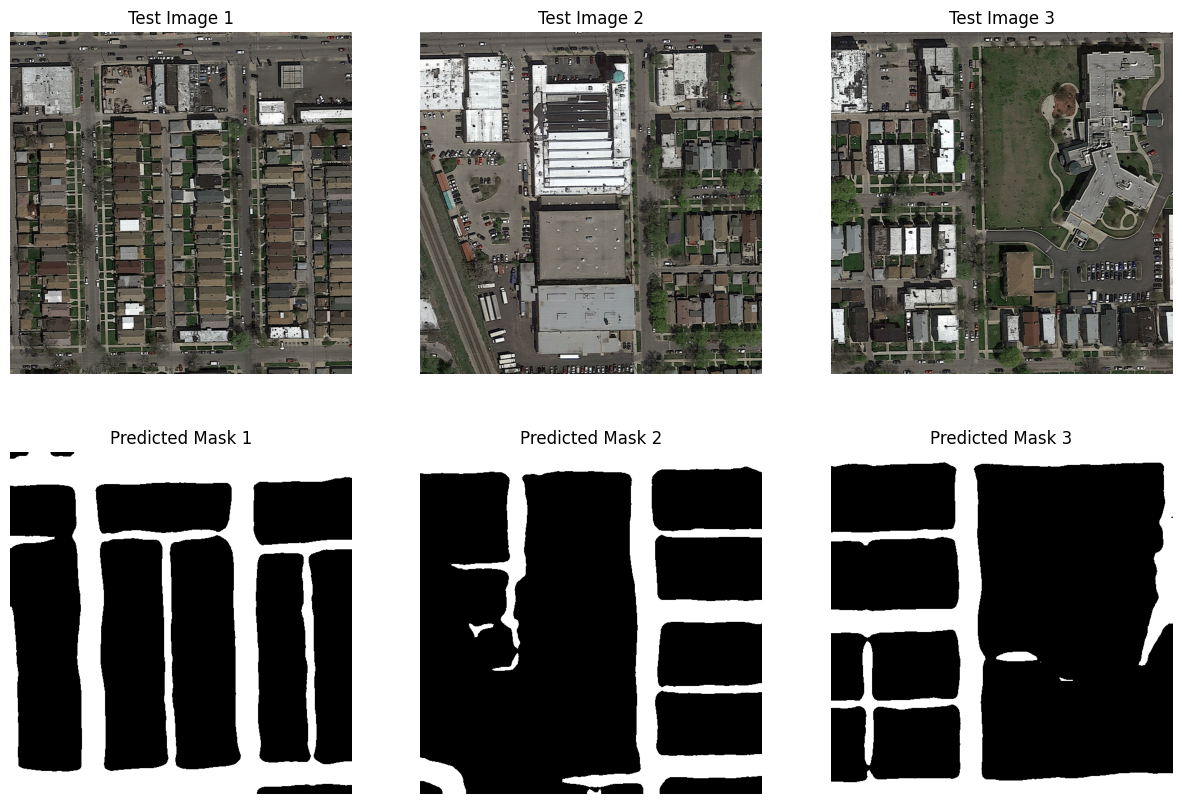

In [26]:
all_imgs = []
for i in range(1,51):
    path = "/home/efe/Desktop/ml-project-2-middle_earth/test/" + f"test_{i}.png"
    image = Image.open(path)
    image = np.array(image).astype(np.float32)
    image = image / 255.0
    all_imgs.append(image)


plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(all_imgs[0])
plt.title("Test Image 1")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(all_imgs[1])
plt.title("Test Image 2")
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(all_imgs[2])
plt.title("Test Image 3")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(all_preds[0],cmap="gray")
plt.title("Predicted Mask 1")
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(all_preds[1],cmap="gray")
plt.title("Predicted Mask 2")
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(all_preds[2],cmap="gray")
plt.title("Predicted Mask 3")
plt.axis("off")
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/segformer_figures/segformer_predictions.png")
plt.show()

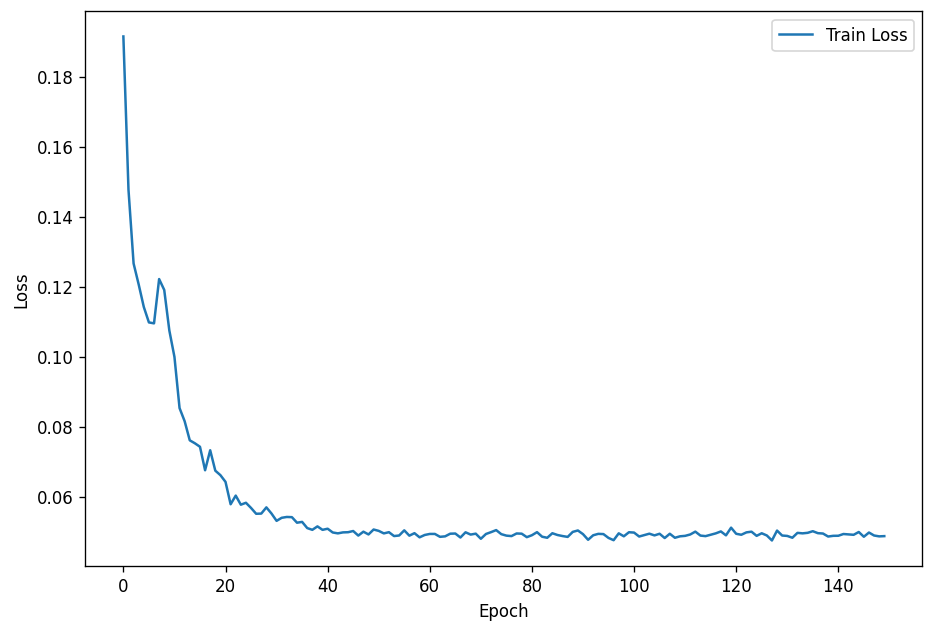

In [27]:
plt.figure(figsize=(9,6),dpi = 120)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/segformer_figures/segformer_losses.png")
plt.show()


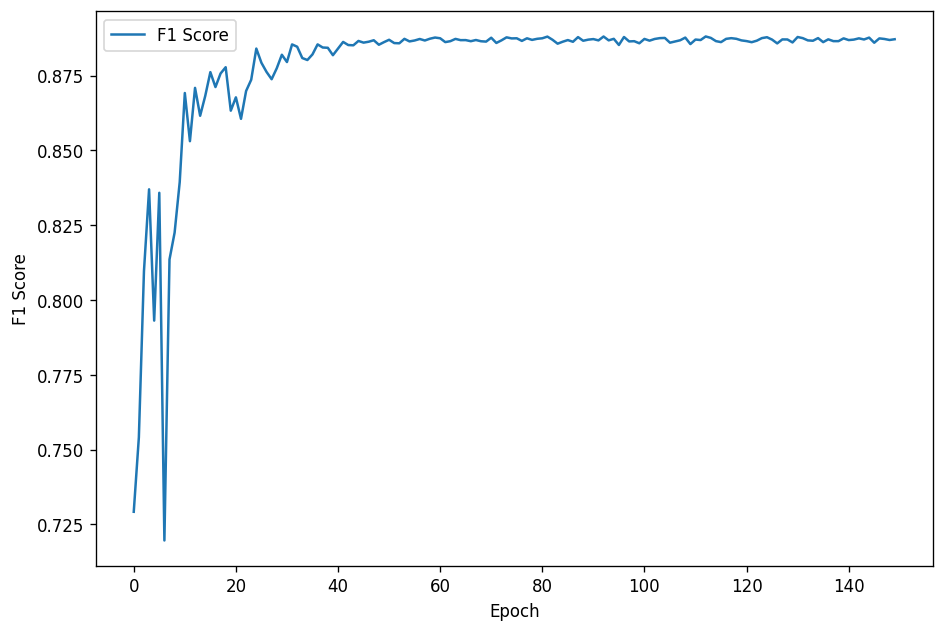

In [28]:
plt.figure(figsize=(9,6),dpi = 120)
plt.plot(f1_scores, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/segformer_figures/segformer_f1_scores.png")
plt.show()
